## How To Plot a Voronoi Diagram

There is a convinient method to generate Vornoi diagrams in `scipy` called: `scipy.spatial.Vornoi`. To illustrate how to use it, let's start with a simple dataset

In [1]:
# imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Disable jedi autocompleter
%config Completer.use_jedi = False

In [2]:
x = [0, 0, 0, 1, 1, 1, 2, 2, 2]
y = [0, 1, 2, 0, 1, 2, 0, 1, 2]

points = np.array([x, y]).T

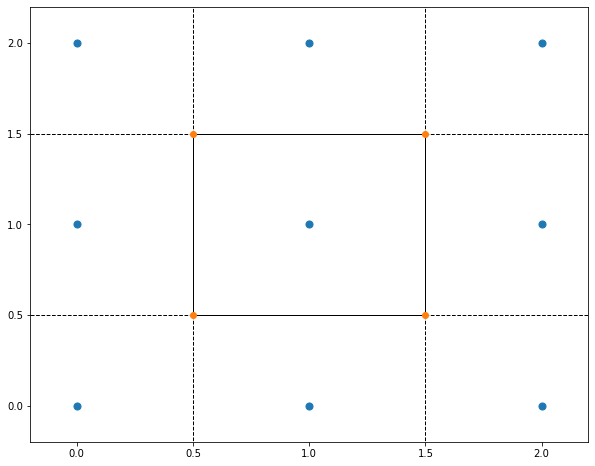

In [3]:
# generate Voronoi tesselation
voro = Voronoi(points)
plt.rcParams["figure.figsize"] = 10,8
fig = voronoi_plot_2d(voro)
plt.scatter(x, y, s=50)

The voronoi vertices (nodes) are the points equidistant to three (or more) sites. These are the orange dots in the above pictures and their coordinates are obtained as follows: 

In [4]:
# The voronoi vertices are:
voro.vertices

array([[0.5, 0.5],
       [0.5, 1.5],
       [1.5, 0.5],
       [1.5, 1.5]])

In [5]:
voro.regions

[[],
 [-1, 0],
 [-1, 1],
 [1, -1, 0],
 [3, -1, 2],
 [-1, 3],
 [-1, 2],
 [0, 1, 3, 2],
 [2, -1, 0],
 [3, -1, 1]]

-1 indicates that a vertex is outside the Voronoi region.
Since the selected points are equidistants we obtained a symmetrical Vornoi diagram. However, this an exception and in practice, the points are randomly distributed.


In [6]:
N_points = 120
points = np.random.uniform(size=[N_points, 2])

Let's add another point with x=1 y=1, just to see how to do that

In [7]:
points = np.vstack([points, [1.0, 1.0]])

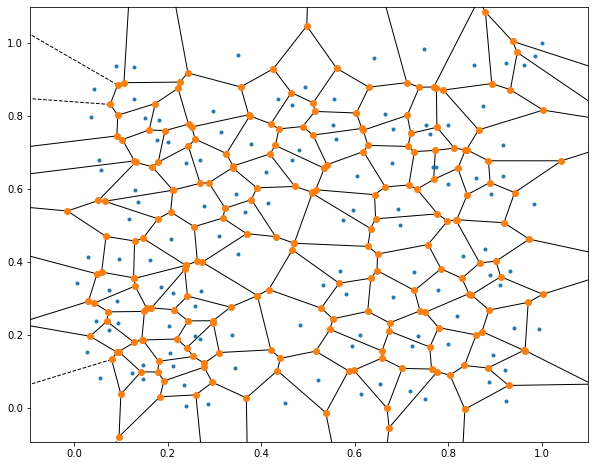

In [8]:
voro = Voronoi(points, qhull_options='Qbb Qc Qx')
plt.rcParams["figure.figsize"] = 10,8
fig = voronoi_plot_2d(voro)

In order to assign each cell a color representing a physical quantity, we need to map the values of this physical quality to a normalized colormap:

In [9]:
phy = np.random.uniform(low=0.0, high=5.5, size=N_points + 1)

# find min/max values for normalization
minima = min(phy)
maxima = max(phy)

# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Paired)

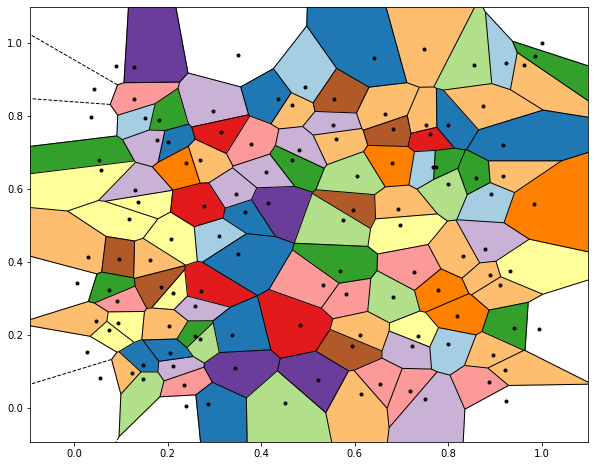

In [26]:
# plot Voronoi diagram, and fill finite regions with color mapped from phy
voronoi_plot_2d(voro, show_points=False, show_vertices=False, s=1, qhull_options='Qbb Qc Qx')

for r in range(len(voro.point_region)):
    region = voro.regions[voro.point_region[r]]
    if not -1 in region:
        poly = [voro.vertices[i] for i in region]
        plt.fill(*zip(*poly), color=mapper.to_rgba(phy[r]))

plt.plot(points[:,0], points[:,1], 'k.')
plt.show()

Infinite polygons are not colored.
To obtain all cells colored we have to reconstruct infinite Voronoi regions in a 2D diagram finite regions. The below function does just that

In [11]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

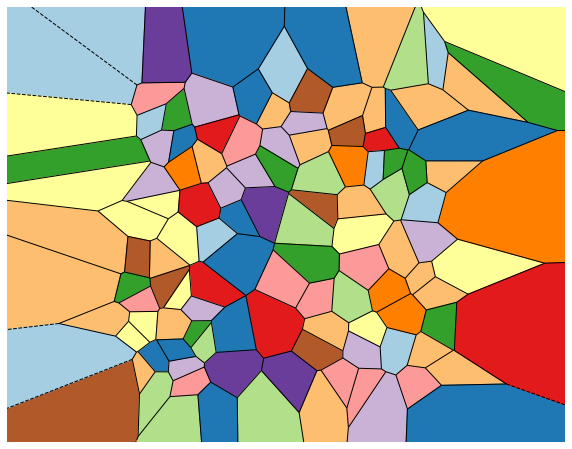

In [25]:
regions, vertices = voronoi_finite_polygons_2d(voro)
voronoi_plot_2d(voro, show_points=False, show_vertices=False, s=1, qhull_options='Qbb Qc Qx')


for i, r in enumerate(regions):
    polygon = vertices[r]
    plt.fill(*zip(*polygon), color=mapper.to_rgba(phy[i]))
    
#plt.plot(points[:,0], points[:,1], '.', color='gray')
plt.axis('equal')
plt.xlim(voro.min_bound[0] - 0.1, voro.max_bound[0] + 0.1)
plt.ylim(voro.min_bound[1] - 0.1, voro.max_bound[1] + 0.1)
plt.axis('off');